In [16]:
import pandas as pd
from collections import Counter
from tqdm import tqdm

In [189]:
train = pd.read_csv('train.txt', delimiter=' ', names=['word', 'tag', 'tag2'])
test = pd.read_csv('test.txt', delimiter=' ', names=['word', 'tag', 'tag2'])

# Shifting the tags back to get previous tags.
# Assuming that None should actually be period.
train['prev_tag'] = train.tag.shift(1).map(lambda x: '.' if x == None else x)
test['prev_tag'] = test.tag.shift(1).map(lambda x: '.' if x == None else x)

In [190]:
test

,word,tag,tag2,prev_tag
0,Rockwell,NNP,B-NP,.
1,International,NNP,I-NP,NNP
2,Corp.,NNP,I-NP,NNP
3,'s,POS,B-NP,NNP
4,Tulsa,NNP,I-NP,POS
...,...,...,...,...
47372,according,VBG,B-PP,","
47373,to,TO,B-PP,VBG
47374,Mr.,NNP,B-NP,TO
47375,Harlow,NNP,I-NP,NNP


In [191]:
train

,word,tag,tag2,prev_tag
0,Confidence,NN,B-NP,.
1,in,IN,B-PP,NN
2,the,DT,B-NP,IN
3,pound,NN,I-NP,DT
4,is,VBZ,B-VP,NN
...,...,...,...,...
211722,to,TO,B-PP,PRP
211723,San,NNP,B-NP,TO
211724,Francisco,NNP,I-NP,NNP
211725,instead,RB,B-ADVP,NNP


## Estimate Emission Probability
$$P(T_i|W_i)=\frac{P(W_i|T_i)P(T_i)}{P(W_i)}$$

$$P(W_i|T_i)=\frac{\text{\# times word and type appear together}}{\text{\# of times type appears}}$$

$$P(T)=\frac{\text{\# instances of type}}{\text{\# entries}}$$

$$P(W)=\frac{\text{\# instances of word}}{\text{\# entries}}$$

In [98]:
smooth_const = float(0.00000001)

In [192]:
word_counter = Counter(train.word)
tag_counter = Counter(train.tag)
word_counters_by_tag = {}
tag_counters_by_prev_tag = {}
tag_set = set(train.tag)
prev_tag_set = set(train.prev_tag)
for T in tag_set:
    t_subset = train[train.tag == T]
    word_counters_by_tag[T] = Counter(t_subset.word)

for Tprev in prev_tag_set:
    tprev_subset = train[train.prev_tag == Tprev]
    tag_counters_by_prev_tag[Tprev] = Counter(tprev_subset.tag)

def Pt(T=''):
    c = tag_counter[T]
    return smooth_const if c == 0 else c / tag_counter.total()

def Pw(W=''):
    c = word_counter[W]
    return smooth_const if c == 0 else c / word_counter.total()

def Pwt(W='', T=''):
    ctr = word_counters_by_tag[T]
    if ctr == None:
        return smooth_const
    c = ctr[W]
    return smooth_const if c == 0 else c / ctr.total()

def Ptw(T='', W=''):
    w = Pw(W=W)
    # If W isn't found, the probably gets really high.
    if w == smooth_const:
        return smooth_const
    return Pwt(W=W, T=T) * Pt(T=T) / w

In [174]:
Pw('the')

0.04354191954734162

In [101]:
Pt(T='DT')

0.08659736358612742

In [102]:
Pwt("the", "DT")

0.5018816471229888

In [175]:
Ptw("DT", "the")

0.9981559822106519

In [104]:
def Emit_greedy(W=''):
    return max([(T, Ptw(T=T, W=W)) for T in tag_set], key=lambda x: x[1])

### Emission Accuracy: 89.4%

In [105]:
emission_results = [row.tag == Emit_greedy(W=row.word)[0] for (_index, row) in tqdm(test.iterrows(), total=len(test))]

100%|█████████████████████████████████████████████████████████████| 47377/47377 [01:36<00:00, 493.33it/s]


In [106]:
sum(emission_results) / len(emission_results)

0.8938725541929629

## Estimate Transition Probabilities
$$P(T_{i+1}|T_i)=\frac{\text{\# instances of tag and next tag}}{\text{\# instances of tag}}$$

In [165]:
def Pt_tprev(T='', Tprev=''):
    ctr = tag_counters_by_prev_tag[Tprev]
    if ctr == None:
        return smooth_const
    c = ctr[T]
    return smooth_const if c == 0 else c / ctr.total()

In [168]:
Pt_tprev(T='DT', Tprev='NNP')

0.002615167974250654

In [169]:
Pt_tprev(T='NNP', Tprev='NNP')

0.39011265338966

### Transition Accuracy: 30.1%

In [258]:
trans_greedy_results = []

def Trans_greedy(Tprev=''):
    return max([(T, Pt_tprev(T=T, Tprev=Tprev)) for T in tag_set], key=lambda x: x[1])

In [259]:
transition_results = [row.tag == Trans_greedy(Tprev=row.prev_tag)[0] for (_index, row) in tqdm(test.iterrows(), total=len(test))]

100%|███████████████████████████████████████████████████████████| 47377/47377 [00:01<00:00, 40489.22it/s]


In [260]:
sum(transition_results) / len(transition_results)

0.30077885893999196

### Emission & Transition Accuracy: 92.2%

In [242]:
model_guesses = []
last_tag = None
def PEmitTrans(W='', T=''):
    a = Ptw(T=T, W=W)
    if last_tag != None:
        a *= Pt_tprev(T=T, Tprev=last_tag)
    return a

for _i, row in tqdm(test.iterrows(), total=len(test)):
    max_tag = max([(T, PEmitTrans(W=row.word, T=T)) for T in tag_set], key=lambda x: x[1])
    last_tag = max_tag[0];
    model_guesses.append((row.tag, max_tag[0]))

100%|█████████████████████████████████████████████████████████████| 47377/47377 [01:39<00:00, 477.72it/s]


In [243]:
sum([1 for x in model_guesses if x[0] == x[1]]) / len(model_guesses)

0.9222829643075754

## Confusion Matrix

In [244]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [245]:
true_pred_df = pd.DataFrame(model_guesses, columns=['true', 'pred'])
mat = confusion_matrix(true_pred_df.true, true_pred_df.pred, labels=list(tag_set))
mat

array([[ 185,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    1, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,  821,    0,    0],
       [   0,    0,    0, ...,    0,  866,    6],
       [   0,    0,    0, ...,    1,    0, 1165]], shape=(44, 44))

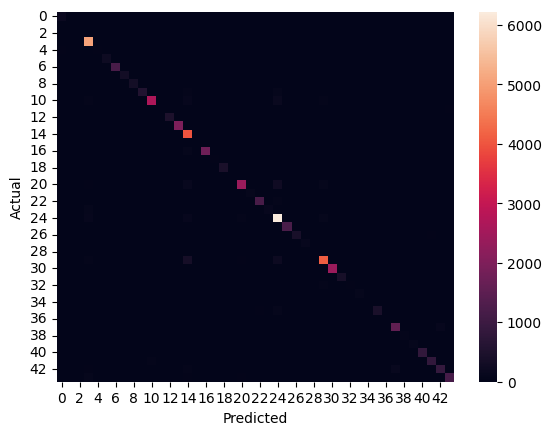

In [246]:
sns.heatmap(mat)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [247]:
print(classification_report(true_pred_df.true, true_pred_df.pred, zero_division=0.0))

              precision    recall  f1-score   support

           #       1.00      0.82      0.90        11
           $       1.00      0.99      1.00       384
          ''       1.00      0.95      0.97       316
           (       1.00      0.96      0.98        77
           )       1.00      0.99      0.99        77
           ,       1.00      1.00      1.00      2390
           .       1.00      1.00      1.00      1975
           :       1.00      1.00      1.00       238
          CC       1.00      1.00      1.00      1214
          CD       1.00      0.92      0.96      1918
          DT       0.80      0.99      0.89      4020
          EX       1.00      0.35      0.52        48
          FW       1.00      0.75      0.86         4
          IN       0.90      1.00      0.95      5071
          JJ       0.94      0.81      0.87      2964
         JJR       0.83      0.92      0.87       202
         JJS       1.00      0.94      0.97        77
          MD       1.00    

## Mistakes my Tagger makes:
Generally when the training data has a primary word (or words) occurring, the recall tends to drop off quite a bit. This is showing to be the case regardless of instances in the training data. Essentially, my model is giving low entropy to those tags due to the data favoring a given few words over the others. This results in a low recall, but a good percision.

Specifically from the confusion matrix heatmap, you can see that there are some significantly accurate tags, but only a few in comparison to all the tags. This is, again, a side-effect of having more occurrences of some tags over other most of the others, resulting in lower entropy when we try to guess a given tag. I would be interested to see what would happen if we 

## Tinkering: Not part of the assignment
Removing the top tags in the training data from the guesses to saturate the heatmap.

In [248]:
top_tags = [x[0] for x in tag_counter.most_common(10)]
top_tags

['NN', 'IN', 'NNP', 'DT', 'NNS', 'JJ', ',', '.', 'CD', 'VBD']

In [249]:
trimmed_guesses = [x for x in model_guesses if x[0] not in top_tags]

In [250]:
trimmed_df = pd.DataFrame(trimmed_guesses, columns=['true', 'pred'])
trimmed_mat = confusion_matrix(
    trimmed_df.true,
    trimmed_df.pred,
    labels=list([T for T in tag_set if T not in top_tags])
)
trimmed_mat

array([[ 185,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    1, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,  821,    0,    0],
       [   0,    0,    0, ...,    0,  866,    6],
       [   0,    0,    0, ...,    1,    0, 1165]], shape=(34, 34))

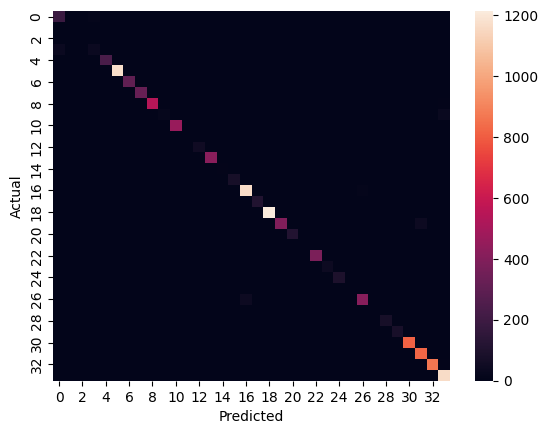

In [251]:
sns.heatmap(trimmed_mat)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Shows a bit more even, but still not perfect. It did seem to remove some outliers, despite increasing the heatmap sensitivity indicating that despite them being the more common tags, they still show quite a few mistakes, likely due to my observations above.